<a href="https://colab.research.google.com/github/sdesai38/5105_SD/blob/main/ArrivalDelayModels5105_project_orb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECGR 5105 Final Project: FAA Flight Delay Dataset
**Owen Bailey-Waltz (801488178)**,
**Shamik Desai (801189802)**
[Link to dataset on Kaggle](https://www.kaggle.com/datasets/hrishitpatil/flight-data-2024)

In [ ]:
# import required packages, load data
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn import datasets, metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from IPython.display import display

In [ ]:
# check for CUDA
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Now training on device {device}')

Now training on device cuda


In [ ]:
#!pip install kaggle

In [ ]:
# data import code (from Kaggle)
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "flight_data_2024.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "hrishitpatil/flight-data-2024",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md
)

print("First 5 records:")
display(df.head())

/tmp/ipython-input-2032139145.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'flight-data-2024' dataset.


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


First 5 records:


,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


In [ ]:
# pre-process data with PyTorch
# note: flight number is not included since carrier and scheduled departure
# time both already convey this information
# serialize dates
flight_inputs = df[['year', 'month', 'day_of_month','day_of_week', 'op_unique_carrier',
                    'origin', 'dest', 'crs_dep_time', 'crs_arr_time', 'distance', 'dep_delay', 'crs_elapsed_time', 'taxi_out' ]]
#fl_date = np.zeros(len(flight_inputs))
#for i in range(len(flight_inputs)):
#  fl_day = datetime.date(df['year'][i], df['month'][i],
#                         df['day_of_month'][i]) - datetime.date(2023,12,31)
#  fl_date[i] = fl_day.days
#display(fl_date)

In [ ]:
flight_inputs.pop('year')
#flight_inputs.pop('month')
#flight_inputs.pop('day_of_month')
flight_inputs

,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,distance,dep_delay,crs_elapsed_time,taxi_out
0,1,1,1,9E,JFK,DTW,1252,1508,509.0,-5.0,136.0,31.0
1,1,1,1,9E,MSP,CLE,1015,1325,622.0,-14.0,130.0,20.0
2,1,1,1,9E,JFK,RIC,1415,1601,288.0,-4.0,106.0,21.0
3,1,1,1,9E,RIC,JFK,1650,1841,288.0,-7.0,111.0,13.0
4,1,1,1,9E,DTW,MKE,1015,1034,237.0,-5.0,79.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12,31,2,YX,MYR,LGA,1226,1423,563.0,-6.0,117.0,14.0
7079077,12,31,2,YX,JFK,PWM,950,1119,273.0,-11.0,89.0,17.0
7079078,12,31,2,YX,PWM,JFK,1200,1329,273.0,-7.0,89.0,25.0
7079079,12,31,2,YX,JFK,SYR,1530,1659,209.0,-6.0,89.0,30.0


In [ ]:
#flight_inputs.insert(0, 'fl_date', fl_date)
flight_inputs

,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,distance,dep_delay,crs_elapsed_time,taxi_out
0,1,1,1,9E,JFK,DTW,1252,1508,509.0,-5.0,136.0,31.0
1,1,1,1,9E,MSP,CLE,1015,1325,622.0,-14.0,130.0,20.0
2,1,1,1,9E,JFK,RIC,1415,1601,288.0,-4.0,106.0,21.0
3,1,1,1,9E,RIC,JFK,1650,1841,288.0,-7.0,111.0,13.0
4,1,1,1,9E,DTW,MKE,1015,1034,237.0,-5.0,79.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12,31,2,YX,MYR,LGA,1226,1423,563.0,-6.0,117.0,14.0
7079077,12,31,2,YX,JFK,PWM,950,1119,273.0,-11.0,89.0,17.0
7079078,12,31,2,YX,PWM,JFK,1200,1329,273.0,-7.0,89.0,25.0
7079079,12,31,2,YX,JFK,SYR,1530,1659,209.0,-6.0,89.0,30.0


In [ ]:
#serialize airline carrier codes and FAA airport codes
display(pd.Categorical(flight_inputs['op_unique_carrier']).codes)
display(pd.Categorical(flight_inputs['origin']).codes)
display(pd.Categorical(flight_inputs['dest']).codes)
flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
flight_inputs['dest'] = pd.Categorical(flight_inputs['dest']).codes
flight_inputs

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int8)

array([173, 227, 173, ..., 268, 173, 324], dtype=int16)

array([ 98,  67, 275, ..., 173, 324, 173], dtype=int16)

/tmp/ipython-input-2794114773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
/tmp/ipython-input-2794114773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
/tmp/ipython-input-2794114773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,distance,dep_delay,crs_elapsed_time,taxi_out
0,1,1,1,0,173,98,1252,1508,509.0,-5.0,136.0,31.0
1,1,1,1,0,227,67,1015,1325,622.0,-14.0,130.0,20.0
2,1,1,1,0,173,275,1415,1601,288.0,-4.0,106.0,21.0
3,1,1,1,0,275,173,1650,1841,288.0,-7.0,111.0,13.0
4,1,1,1,0,98,217,1015,1034,237.0,-5.0,79.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12,31,2,14,231,193,1226,1423,563.0,-6.0,117.0,14.0
7079077,12,31,2,14,173,268,950,1119,273.0,-11.0,89.0,17.0
7079078,12,31,2,14,268,173,1200,1329,273.0,-7.0,89.0,25.0
7079079,12,31,2,14,173,324,1530,1659,209.0,-6.0,89.0,30.0


In [ ]:
# look for null values and replace with mean
# chosen input features should not have any null values based on previous
# inspection of dataset
flight_inputs.isnull().sum() * 100 / flight_inputs.shape[0]

,0
month,0.000000
day_of_month,0.000000
day_of_week,0.000000
op_unique_carrier,0.000000
origin,0.000000
dest,0.000000
crs_dep_time,0.000000
crs_arr_time,0.000000
distance,0.000000
dep_delay,1.313306


In [ ]:
# make sure everything is float32 for use in neural network applications
# fill null values in arr_delay before converting to tensor
flight_inputs['dep_delay'] = flight_inputs['dep_delay'].fillna(0)
flight_inputs['crs_elapsed_time'] = flight_inputs['crs_elapsed_time'].fillna(0)
flight_inputs['taxi_out'] = flight_inputs['taxi_out'].fillna(0)
flight_inputs = flight_inputs.astype(np.float32)
flight_inputs

/tmp/ipython-input-3027631277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['dep_delay'] = flight_inputs['dep_delay'].fillna(0)
/tmp/ipython-input-3027631277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['crs_elapsed_time'] = flight_inputs['crs_elapsed_time'].fillna(0)
/tmp/ipython-input-3027631277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,distance,dep_delay,crs_elapsed_time,taxi_out
0,1.0,1.0,1.0,0.0,173.0,98.0,1252.0,1508.0,509.0,-5.0,136.0,31.0
1,1.0,1.0,1.0,0.0,227.0,67.0,1015.0,1325.0,622.0,-14.0,130.0,20.0
2,1.0,1.0,1.0,0.0,173.0,275.0,1415.0,1601.0,288.0,-4.0,106.0,21.0
3,1.0,1.0,1.0,0.0,275.0,173.0,1650.0,1841.0,288.0,-7.0,111.0,13.0
4,1.0,1.0,1.0,0.0,98.0,217.0,1015.0,1034.0,237.0,-5.0,79.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12.0,31.0,2.0,14.0,231.0,193.0,1226.0,1423.0,563.0,-6.0,117.0,14.0
7079077,12.0,31.0,2.0,14.0,173.0,268.0,950.0,1119.0,273.0,-11.0,89.0,17.0
7079078,12.0,31.0,2.0,14.0,268.0,173.0,1200.0,1329.0,273.0,-7.0,89.0,25.0
7079079,12.0,31.0,2.0,14.0,173.0,324.0,1530.0,1659.0,209.0,-6.0,89.0,30.0


In [ ]:
# replace null delays with zero
delay_label_cols = ['security_delay','arr_delay', 'cancelled']
df[delay_label_cols] = df[delay_label_cols].fillna(0)
df.head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


In [ ]:
# bring in our output features
cancelled = df['cancelled']
dep_delay = df['arr_delay']
security_delay = df['security_delay']


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Inputs (features)
X = flight_inputs   # all columns you listed

# Outputs (multiple ground truths)
y_cancelled = df["cancelled"]        # classification target
y_arr_delay = df["arr_delay"]        # regression target
y_security = df["security_delay"]    # regression target

# -----------------------------
# 1. Train/Test Split (80:20)
# -----------------------------
X_train, X_test, y_cancelled_train, y_cancelled_test, y_arr_train, y_arr_test, y_sec_train, y_sec_test = train_test_split(
    X, y_cancelled, y_arr_delay, y_security,
    test_size=0.2,
    random_state=42   # reproducibility
)

# -----------------------------
# 2. Standardize Inputs
# -----------------------------
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Now you have:
# -----------------------------
# X_train_scaled, X_test_scaled → standardized inputs
# y_cancelled_train/test → ground truth for cancelled
# y_arr_train/test → ground truth for arrival delay
# y_sec_train/test → ground truth for security delay


In [ ]:
#WholeYear = pd.concat([flight_inputs,cancelled,dep_delay,security_delay],axis=1)
#print(WholeYear.head())

Arrival Delay models

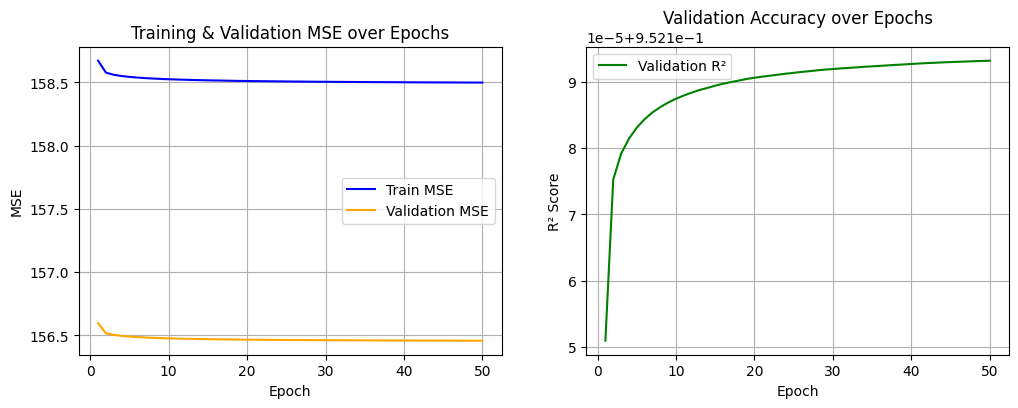

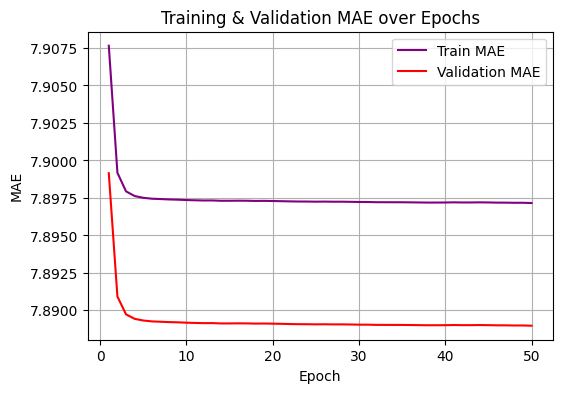

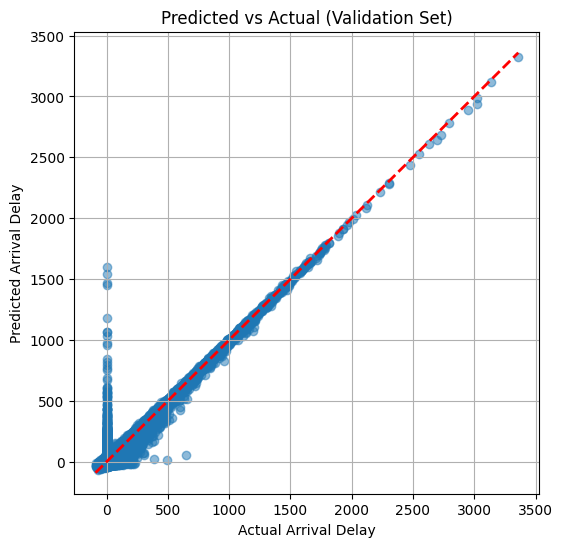

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1. SGDRegressor to simulate epochs
# -----------------------------
n_epochs = 50
train_mse_list = []
val_mse_list = []
train_mae_list = []
val_mae_list = []
val_r2_scores = []

sgd = SGDRegressor(
    max_iter=1,
    tol=None,
    learning_rate='invscaling',
    eta0=0.001,
    random_state=42,
    penalty="l2",
    alpha=0.0001
)

for epoch in range(n_epochs):
    # partial_fit trains one epoch at a time
    sgd.partial_fit(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]], y_arr_train)

    # Predictions
    y_train_pred = sgd.predict(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]])
    y_val_pred = sgd.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

    # Losses
    train_mse = mean_squared_error(y_arr_train, y_train_pred)
    val_mse = mean_squared_error(y_arr_test, y_val_pred)
    train_mae = mean_absolute_error(y_arr_train, y_train_pred)
    val_mae = mean_absolute_error(y_arr_test, y_val_pred)
    val_r2 = r2_score(y_arr_test, y_val_pred)

    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    val_r2_scores.append(val_r2)

# -----------------------------
# 2. Plot Training & Validation MSE
# -----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), train_mse_list, label="Train MSE", color="blue")
plt.plot(range(1, n_epochs+1), val_mse_list, label="Validation MSE", color="orange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training & Validation MSE over Epochs")
plt.legend()
plt.grid(True)

# -----------------------------
# 3. Plot Validation Accuracy (R²)
# -----------------------------
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), val_r2_scores, label="Validation R²", color="green")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 4. Plot Training & Validation MAE
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, n_epochs+1), train_mae_list, label="Train MAE", color="purple")
plt.plot(range(1, n_epochs+1), val_mae_list, label="Validation MAE", color="red")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training & Validation MAE over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5. Predicted vs Actual Scatter Plot
# -----------------------------
y_val_pred_final = sgd.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

plt.figure(figsize=(6,6))
plt.scatter(y_arr_test, y_val_pred_final, alpha=0.5)
plt.plot([y_arr_test.min(), y_arr_test.max()],
         [y_arr_test.min(), y_arr_test.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Predicted vs Actual (Validation Set)")
plt.grid(True)
plt.show()


In [ ]:
print("Coefficients:",sgd.coef_)
print("Intercept:",sgd.intercept_)
print(f"Final Results -> Train MSE: {train_mse_list[-1]:.3f}, "
      f"Val MSE: {val_mse_list[-1]:.3f}, "
      f"Train MAE: {train_mae_list[-1]:.3f}, "
      f"Val MAE: {val_mae_list[-1]:.3f}, "
      f"Val R²: {val_r2_scores[-1]:.4f}")


Coefficients: [ -0.35946038   0.06216878   0.07335587  -0.26249292   0.46375632
  16.25614     55.303997   -18.053007     8.308109  ]
Intercept: [7.02718062]
Final Results -> Train MSE: 158.499, Val MSE: 156.458, Train MAE: 7.897, Val MAE: 7.889, Val R²: 0.9522


In [ ]:
import matplotlib.pyplot as plt

class TrainingPlotter:
    def __init__(self, metrics, y_true=None, y_pred=None):
        """
        metrics: dict containing lists of metrics per epoch
                 keys: 'train_mse', 'val_mse', 'train_mae', 'val_mae', 'val_r2'
        y_true: ground truth values (for scatter plot)
        y_pred: predicted values (for scatter plot)
        """
        self.metrics = metrics
        self.y_true = y_true
        self.y_pred = y_pred

    def plot_losses(self):
        """Plot Training & Validation MSE"""
        plt.figure(figsize=(6,4))
        plt.plot(self.metrics["train_mse"], label="Train MSE", color="blue")
        plt.plot(self.metrics["val_mse"], label="Val MSE", color="orange")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.title("Training & Validation MSE")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_mae(self):
        """Plot Training & Validation MAE"""
        plt.figure(figsize=(6,4))
        plt.plot(self.metrics["train_mae"], label="Train MAE", color="purple")
        plt.plot(self.metrics["val_mae"], label="Val MAE", color="red")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.title("Training & Validation MAE")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_r2(self):
        """Plot Validation R²"""
        plt.figure(figsize=(6,4))
        plt.plot(self.metrics["val_r2"], label="Val R²", color="green")
        plt.xlabel("Epoch")
        plt.ylabel("R² Score")
        plt.title("Validation Accuracy (R²)")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_pred_vs_actual(self):
        """Scatter plot of predicted vs actual values"""
        if self.y_true is None or self.y_pred is None:
            raise ValueError("y_true and y_pred must be provided for scatter plot.")
        plt.figure(figsize=(6,6))
        plt.scatter(self.y_true, self.y_pred, alpha=0.5)
        plt.plot([self.y_true.min(), self.y_true.max()],
                 [self.y_true.min(), self.y_true.max()],
                 'r--', lw=2)  # perfect prediction line
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Predicted vs Actual (Validation Set)")
        plt.grid(True)
        plt.show()


SVR Regression Linear for practicality of training time for millions of datapoints

In [ ]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1. Define SVR model
# -----------------------------
# RBF kernel is common for capturing nonlinear relationships
svr = LinearSVR(C=1.0, epsilon=1.0, max_iter=10000)


# -----------------------------
# 2. Train
# -----------------------------
svr.fit(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]], y_arr_train)

# -----------------------------
# 3. Predict
# -----------------------------
y_train_pred = svr.predict(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]])
y_test_pred  = svr.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

# -----------------------------
# 4. Metrics
# -----------------------------
train_mse = mean_squared_error(y_arr_train, y_train_pred)
train_mae = mean_absolute_error(y_arr_train, y_train_pred)

test_mse = mean_squared_error(y_arr_test, y_test_pred)
test_mae = mean_absolute_error(y_arr_test, y_test_pred)
test_r2  = r2_score(y_arr_test, y_test_pred)

print(f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f}")
print(f"Test MSE={test_mse:.3f}, MAE={test_mae:.3f}, R²={test_r2:.4f}")


Train MSE=160.506, MAE=7.809
Test MSE=158.530, MAE=7.803, R²=0.9516


Coefficients: [-3.44586972e-01  1.51359802e-02  8.76999001e-02 -3.55542937e-01
  2.90452089e-01  1.96932384e+01  5.56616236e+01 -2.14899773e+01
  8.37768195e+00]
Intercept: [5.80436948]


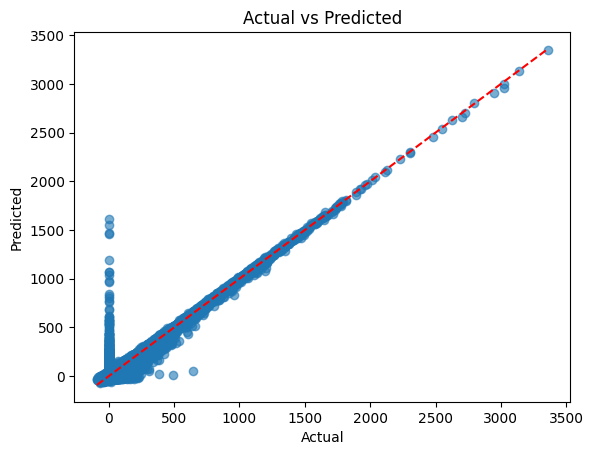

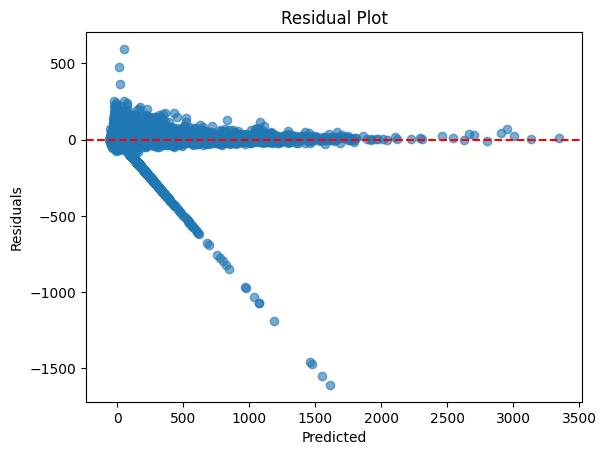

'\n# Histogram of Residuals\nplt.hist(residuals, bins=20, color=\'purple\', edgecolor=\'black\')\nplt.xlabel("Residual")\nplt.ylabel("Frequency")\nplt.title("Histogram of Residuals")\nplt.show()\n'

In [ ]:
print("Coefficients:", svr.coef_)
print("Intercept:", svr.intercept_)

# Use your actual test data and predictions
y_true = y_arr_test
y_pred = y_test_pred

# Actual vs Predicted
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

# Residuals
residuals = y_true - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()
'''
# Histogram of Residuals
plt.hist(residuals, bins=20, color='purple', edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()
'''

In [ ]:
#NN Model
# Here I am choosing a FCNN for the following reason: each flight is independent, therefore it doesnt need to depend on previous pasts states, Time is encoded as features, not sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

#pytorch can embed catagorical values so we seperate
# -----------------------------
# 1. Split into train/test
# -----------------------------
X_train, X_test, y_cancelled_train, y_cancelled_test, y_arr_train, y_arr_test, y_sec_train, y_sec_test = train_test_split(
    flight_inputs,
    df["cancelled"],
    df["arr_delay"],
    df["security_delay"],
    test_size=0.2,
    random_state=42
)

# -----------------------------
# 2. Separate numeric vs categorical
# -----------------------------
numeric_cols = ["month","day_of_month","day_of_week",
                "crs_dep_time","crs_arr_time","distance",
                "dep_delay","crs_elapsed_time","taxi_out"]

cat_cols = ["op_unique_carrier","origin","dest"]

# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num  = scaler.transform(X_test[numeric_cols])

# Keep categorical features as integer codes
X_train_carrier = X_train["op_unique_carrier"].astype(int).values
X_train_origin  = X_train["origin"].astype(int).values
X_train_dest    = X_train["dest"].astype(int).values

X_test_carrier = X_test["op_unique_carrier"].astype(int).values
X_test_origin  = X_test["origin"].astype(int).values
X_test_dest    = X_test["dest"].astype(int).values




In [ ]:
# Unique category counts
num_carriers = df["op_unique_carrier"].nunique()
num_airports = pd.concat([df["origin"], df["dest"]]).nunique()

# Numeric features (scaled)
X_train_num_t = torch.tensor(X_train_num, dtype=torch.float32)
X_test_num_t  = torch.tensor(X_test_num, dtype=torch.float32)

# Categorical features (IDs)
X_train_carrier_t = torch.tensor(X_train_carrier, dtype=torch.long)
X_train_origin_t  = torch.tensor(X_train_origin, dtype=torch.long)
X_train_dest_t    = torch.tensor(X_train_dest, dtype=torch.long)

X_test_carrier_t = torch.tensor(X_test_carrier, dtype=torch.long)
X_test_origin_t  = torch.tensor(X_test_origin, dtype=torch.long)
X_test_dest_t    = torch.tensor(X_test_dest, dtype=torch.long)

# Targets
y_arr_train_t = torch.tensor(y_arr_train.values, dtype=torch.float32).unsqueeze(1)
y_arr_test_t  = torch.tensor(y_arr_test.values, dtype=torch.float32).unsqueeze(1)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class FlightDataset(Dataset):
    def __init__(self, X_num, X_carrier, X_origin, X_dest, y_arr):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_carrier = torch.tensor(X_carrier, dtype=torch.long)
        self.X_origin = torch.tensor(X_origin, dtype=torch.long)
        self.X_dest = torch.tensor(X_dest, dtype=torch.long)
        self.y_arr = torch.tensor(y_arr.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y_arr)

    def __getitem__(self, idx):
        return (self.X_num[idx],
                self.X_carrier[idx],
                self.X_origin[idx],
                self.X_dest[idx],
                self.y_arr[idx])


In [ ]:
batch_size = 1024

train_dataset = FlightDataset(X_train_num, X_train_carrier, X_train_origin, X_train_dest, y_arr_train)
test_dataset  = FlightDataset(X_test_num, X_test_carrier, X_test_origin, X_test_dest, y_arr_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
'''
import torch
import torch.nn as nn

p = 0.3
class FlightDelayFCNN(nn.Module):
    def __init__(self, num_numeric, n_carriers, n_airports,
                 emb_carrier=16, emb_airport=64):
        super().__init__()
        # Embeddings for categorical features
        self.emb_carrier = nn.Embedding(n_carriers, emb_carrier)
        self.emb_origin  = nn.Embedding(n_airports, emb_airport)
        self.emb_dest    = nn.Embedding(n_airports, emb_airport)

        # Total input dimension = numeric + embeddings
        in_dim = num_numeric + emb_carrier + 2*emb_airport

        # FCNN hidden layers
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # regression output: arr_delay
        )

    def forward(self, x_num, x_carrier, x_origin, x_dest):
        # Look up embeddings
        e_car = self.emb_carrier(x_carrier)
        e_org = self.emb_origin(x_origin)
        e_dst = self.emb_dest(x_dest)

        # Concatenate numeric + embeddings
        x = torch.cat([x_num, e_car, e_org, e_dst], dim=1)

        # Pass through FCNN
        return self.fc(x)
'''

In [ ]:

import torch
import torch.nn as nn
#Batchnorm experiment
class FlightDelayFCNN(nn.Module):
    def __init__(self, num_numeric, n_carriers, n_airports,
                 emb_carrier=16, emb_airport=64):
        super().__init__()
        # Embeddings for categorical features
        self.emb_carrier = nn.Embedding(n_carriers, emb_carrier)
        self.emb_origin  = nn.Embedding(n_airports, emb_airport)
        self.emb_dest    = nn.Embedding(n_airports, emb_airport)

        # Total input dimension = numeric + embeddings
        in_dim = num_numeric + emb_carrier + 2*emb_airport

        # FCNN hidden layers with BatchNorm instead of Dropout
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),   # normalize activations of 128-dim layer
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),    # normalize activations of 64-dim layer
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),    # normalize activations of 32-dim layer
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(32, 1)       # regression output: arr_delay
        )

    def forward(self, x_num, x_carrier, x_origin, x_dest):
        # Look up embeddings
        e_car = self.emb_carrier(x_carrier)
        e_org = self.emb_origin(x_origin)
        e_dst = self.emb_dest(x_dest)

        # Concatenate numeric + embeddings
        x = torch.cat([x_num, e_car, e_org, e_dst], dim=1)

        # Pass through FCNN
        return self.fc(x)


In [ ]:
#experiment to wident hidden layers FINAL MODEL UTILIZED
import torch
import torch.nn as nn
#Batchnorm experiment
class FlightDelayFCNN(nn.Module):
    def __init__(self, num_numeric, n_carriers, n_airports,
                 emb_carrier=16, emb_airport=64):
        super().__init__()
        # Embeddings for categorical features
        self.emb_carrier = nn.Embedding(n_carriers, emb_carrier)
        self.emb_origin  = nn.Embedding(n_airports, emb_airport)
        self.emb_dest    = nn.Embedding(n_airports, emb_airport)

        # Total input dimension = numeric + embeddings
        in_dim = num_numeric + emb_carrier + 2*emb_airport

        # FCNN hidden layers with BatchNorm instead of Dropout
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),   # normalize activations of 128-dim layer
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),    # normalize activations of 64-dim layer
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),    # normalize activations of 32-dim layer
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(64, 1)       # regression output: arr_delay
        )

    def forward(self, x_num, x_carrier, x_origin, x_dest):
        # Look up embeddings
        e_car = self.emb_carrier(x_carrier)
        e_org = self.emb_origin(x_origin)
        e_dst = self.emb_dest(x_dest)

        # Concatenate numeric + embeddings
        x = torch.cat([x_num, e_car, e_org, e_dst], dim=1)

        # Pass through FCNN
        return self.fc(x)


gradient accumulation experiment

In [ ]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Now training on device {device}')

# -----------------------------
# Training Setup
# -----------------------------
model = FlightDelayFCNN(num_numeric=9,
                        n_carriers=num_carriers,
                        n_airports=num_airports).to(device)   # move model to device
n_epochs = 15
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

# gradient accumulation steps
accumulation_steps = 4   # effective batch size = batch_size * accumulation_steps

# -----------------------------
# Training Loop (metrics only)
# -----------------------------

metrics = {"train_mse": [], "val_mse": [], "train_mae": [], "val_mae": [], "val_r2": []}

start_time = time.time()   # start timer

for epoch in range(n_epochs):
    # Training
    model.train()
    train_preds, train_targets = [], []

    optimizer.zero_grad()  # clear grads once at start of epoch

    for batch_idx, (x_num, x_car, x_org, x_dst, y) in enumerate(train_loader):
        # move batch tensors to device
        x_num, x_car, x_org, x_dst, y = (
            x_num.to(device),
            x_car.to(device),
            x_org.to(device),
            x_dst.to(device),
            y.to(device)
        )

        # forward + loss
        y_pred = model(x_num, x_car, x_org, x_dst)
        loss = criterion(y_pred, y)

        # normalize loss by accumulation steps
        loss = loss / accumulation_steps
        loss.backward()

        # update only every N batches
        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # collect predictions for metrics
        train_preds.append(y_pred.detach().cpu())
        train_targets.append(y.detach().cpu())

    # Compute train metrics
    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_mse = mean_squared_error(train_targets, train_preds)
    train_mae = mean_absolute_error(train_targets, train_preds)

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for x_num, x_car, x_org, x_dst, y in test_loader:
            x_num, x_car, x_org, x_dst, y = (
                x_num.to(device),
                x_car.to(device),
                x_org.to(device),
                x_dst.to(device),
                y.to(device)
            )
            y_pred = model(x_num, x_car, x_org, x_dst)
            val_preds.append(y_pred.cpu())   # move back to CPU for metrics
            val_targets.append(y.cpu())

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_mse = mean_squared_error(val_targets, val_preds)
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    # step scheduler once per epoch
    scheduler.step()

    # Store metrics
    metrics["train_mse"].append(train_mse)
    metrics["val_mse"].append(val_mse)
    metrics["train_mae"].append(train_mae)
    metrics["val_mae"].append(val_mae)
    metrics["val_r2"].append(val_r2)

    print(f"Epoch {epoch+1:02d} | "
          f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f} | "
          f"Val MSE={val_mse:.3f}, MAE={val_mae:.3f}, R²={val_r2:.4f}")

end_time = time.time()   # end timer
elapsed = end_time - start_time
print(f"\nTotal training time for {n_epochs} epochs: {elapsed:.2f} seconds")


Now training on device cuda
Epoch 01 | Train MSE=2773.190, MAE=21.616 | Val MSE=2311.378, MAE=19.491, R²=0.2937
Epoch 02 | Train MSE=2039.925, MAE=17.366 | Val MSE=1577.242, MAE=15.712, R²=0.5181
Epoch 03 | Train MSE=1395.152, MAE=14.229 | Val MSE=1014.665, MAE=13.135, R²=0.6900
Epoch 04 | Train MSE=888.974, MAE=11.747 | Val MSE=465.159, MAE=10.197, R²=0.8579
Epoch 05 | Train MSE=553.390, MAE=9.819 | Val MSE=482.817, MAE=10.454, R²=0.8525
Epoch 06 | Train MSE=376.052, MAE=8.764 | Val MSE=183.786, MAE=7.738, R²=0.9438
Epoch 07 | Train MSE=309.810, MAE=8.443 | Val MSE=133.014, MAE=7.011, R²=0.9594
Epoch 08 | Train MSE=266.817, MAE=8.178 | Val MSE=136.684, MAE=7.107, R²=0.9582
Epoch 09 | Train MSE=231.756, MAE=7.939 | Val MSE=132.995, MAE=7.042, R²=0.9594
Epoch 10 | Train MSE=212.587, MAE=7.769 | Val MSE=132.751, MAE=6.954, R²=0.9594
Epoch 11 | Train MSE=200.325, MAE=7.677 | Val MSE=131.705, MAE=6.910, R²=0.9598
Epoch 12 | Train MSE=195.425, MAE=7.626 | Val MSE=131.359, MAE=6.962, R²=0.95

In [ ]:
# -----------------------------
# Save the trained model weights
# -----------------------------
torch.save(model.state_dict(), "flight_delay_model.pth")
print("Model saved successfully!")

# -----------------------------
# Reload the model
# -----------------------------
model = FlightDelayFCNN(num_numeric=9,
                        n_carriers=num_carriers,
                        n_airports=num_airports).to(device)
model.load_state_dict(torch.load("flight_delay_model.pth"))
model.eval()   # set to inference mode
print("Model reloaded successfully!")

# -----------------------------
# Print weights and biases
# -----------------------------
print("\n--- Model Parameters (Weights & Biases) ---")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data}\n")


Model saved successfully!
Model reloaded successfully!

--- Model Parameters (Weights & Biases) ---
emb_carrier.weight:
tensor([[-3.8064e-01, -1.0154e+00,  2.1410e-01,  6.4350e-01,  2.1216e+00,
         -9.7907e-01, -1.6420e+00, -9.8170e-01, -8.9426e-01, -1.2503e+00,
         -4.9698e-01, -7.4145e-01, -3.8354e-01,  8.1182e-01, -4.8206e-01,
         -2.4363e-01],
        [ 1.0484e+00, -2.3909e-01, -1.8026e+00, -9.1444e-01, -1.1619e+00,
          1.3039e+00, -8.8508e-01,  7.2771e-02, -9.6077e-01, -9.1859e-01,
          1.3806e-02, -5.2707e-01, -8.3808e-01,  5.4712e-01, -4.2573e-01,
          4.7059e-01],
        [ 7.9713e-01,  4.1500e-01, -1.5434e+00,  1.1296e+00,  7.6682e-01,
          1.3311e+00, -1.7212e+00,  2.2567e+00,  4.9602e-01, -3.4215e-01,
          1.2493e+00, -1.6303e+00, -1.2218e+00,  8.6282e-02, -1.2218e+00,
          9.5942e-01],
        [-2.1749e-01, -4.3069e-01, -2.0219e+00,  6.8633e-01,  7.8683e-01,
          8.2429e-01, -7.5198e-01,  3.4512e-01, -7.9725e-01, -9.2231e-0

In [ ]:
# -----------------------------
# Final predictions for scatter plot (to be plotted externally)
# -----------------------------
model.eval()
with torch.no_grad():
    y_val_pred_batches = []
    for x_num, x_car, x_org, x_dst, y in test_loader:
        x_num, x_car, x_org, x_dst = (
            x_num.to(device),
            x_car.to(device),
            x_org.to(device),
            x_dst.to(device)
        )
        preds = model(x_num, x_car, x_org, x_dst)
        y_val_pred_batches.append(preds.cpu())
    final_val_pred = torch.cat(y_val_pred_batches).numpy()


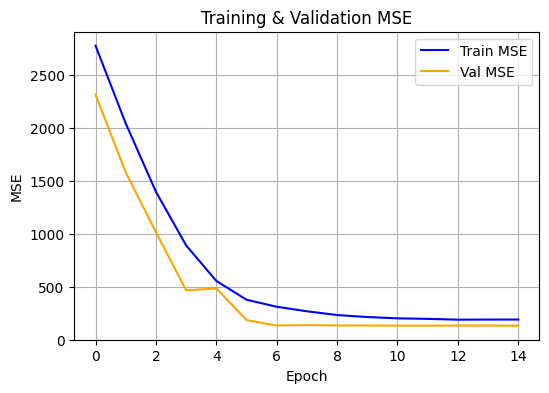

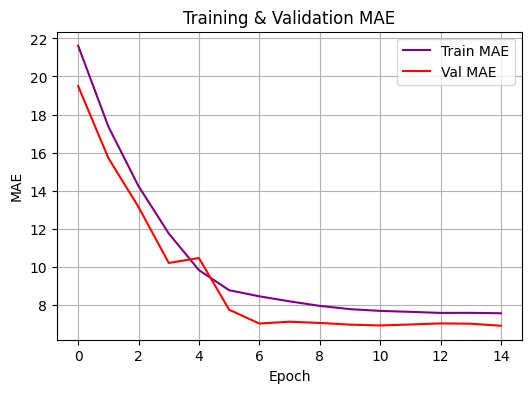

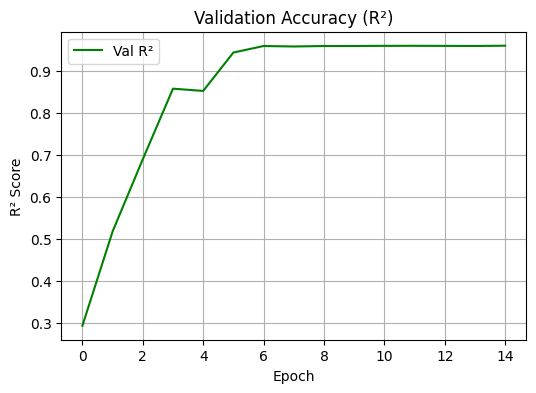

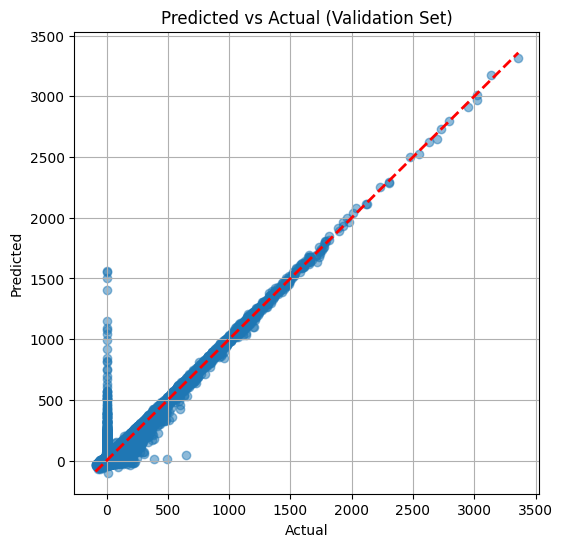

In [ ]:
plotter = TrainingPlotter(metrics, y_true=y_arr_test_t.numpy(), y_pred=final_val_pred)

plotter.plot_losses()
plotter.plot_mae()
plotter.plot_r2()
plotter.plot_pred_vs_actual()
#latest, figure out what changes i put after
#lr = 1e-4, decayt = 1e-6, sccum = 4, hidden layer 256, batch = 1024
'''
Now training on device cuda
Epoch 01 | Train MSE=2773.190, MAE=21.616 | Val MSE=2311.378, MAE=19.491, R²=0.2937
Epoch 02 | Train MSE=2039.925, MAE=17.366 | Val MSE=1577.242, MAE=15.712, R²=0.5181
Epoch 03 | Train MSE=1395.152, MAE=14.229 | Val MSE=1014.665, MAE=13.135, R²=0.6900
Epoch 04 | Train MSE=888.974, MAE=11.747 | Val MSE=465.159, MAE=10.197, R²=0.8579
Epoch 05 | Train MSE=553.390, MAE=9.819 | Val MSE=482.817, MAE=10.454, R²=0.8525
Epoch 06 | Train MSE=376.052, MAE=8.764 | Val MSE=183.786, MAE=7.738, R²=0.9438
Epoch 07 | Train MSE=309.810, MAE=8.443 | Val MSE=133.014, MAE=7.011, R²=0.9594
Epoch 08 | Train MSE=266.817, MAE=8.178 | Val MSE=136.684, MAE=7.107, R²=0.9582
Epoch 09 | Train MSE=231.756, MAE=7.939 | Val MSE=132.995, MAE=7.042, R²=0.9594
Epoch 10 | Train MSE=212.587, MAE=7.769 | Val MSE=132.751, MAE=6.954, R²=0.9594
Epoch 11 | Train MSE=200.325, MAE=7.677 | Val MSE=131.705, MAE=6.910, R²=0.9598
Epoch 12 | Train MSE=195.425, MAE=7.626 | Val MSE=131.359, MAE=6.962, R²=0.9599
Epoch 13 | Train MSE=187.863, MAE=7.570 | Val MSE=132.140, MAE=7.017, R²=0.9596
Epoch 14 | Train MSE=188.879, MAE=7.573 | Val MSE=132.654, MAE=7.001, R²=0.9595
Epoch 15 | Train MSE=189.126, MAE=7.552 | Val MSE=130.744, MAE=6.897, R²=0.9601

Total training time for 15 epochs: 2451.62 seconds
'''

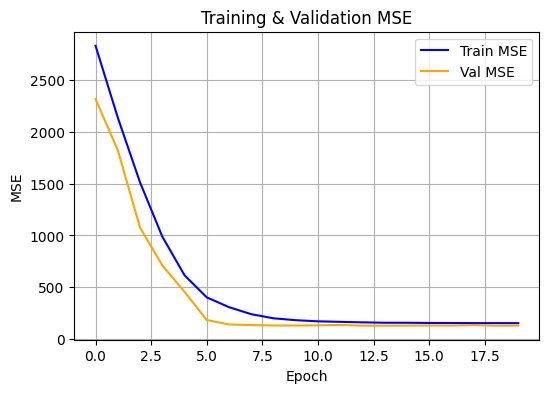

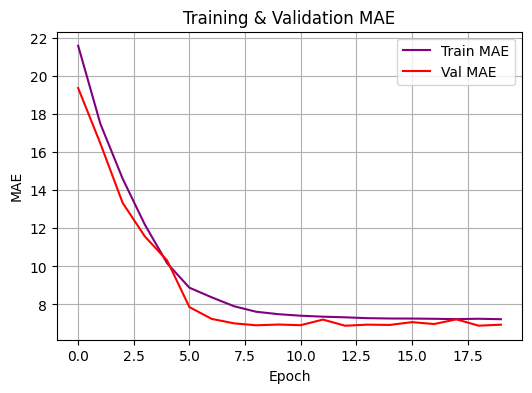

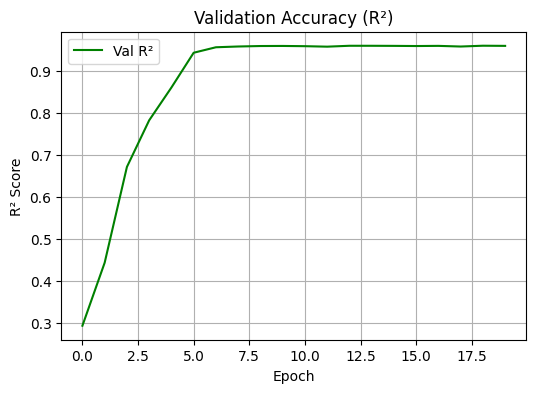

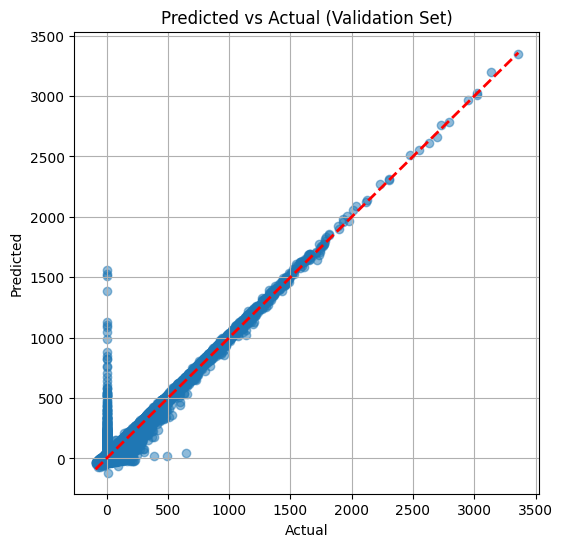

In [ ]:
plotter = TrainingPlotter(metrics, y_true=y_arr_test_t.numpy(), y_pred=final_val_pred)

plotter.plot_losses()
plotter.plot_mae()
plotter.plot_r2()
plotter.plot_pred_vs_actual()
#latest, figure out what changes i put after
#lr = 1e-4, decayt = 1e-5, sccum = 4, hidden layer 256, batch = 1024
'''
Epoch 01 | Train MSE=2831.118, MAE=21.610 | Val MSE=2315.891, MAE=19.383, R²=0.2924
Epoch 02 | Train MSE=2137.651, MAE=17.495 | Val MSE=1823.684, MAE=16.461, R²=0.4428
Epoch 03 | Train MSE=1511.701, MAE=14.614 | Val MSE=1075.381, MAE=13.342, R²=0.6714
Epoch 04 | Train MSE=989.534, MAE=12.193 | Val MSE=711.266, MAE=11.573, R²=0.7827
Epoch 05 | Train MSE=615.313, MAE=10.163 | Val MSE=454.863, MAE=10.309, R²=0.8610
Epoch 06 | Train MSE=401.921, MAE=8.880 | Val MSE=183.135, MAE=7.859, R²=0.9440
Epoch 07 | Train MSE=307.521, MAE=8.374 | Val MSE=140.345, MAE=7.240, R²=0.9571
Epoch 08 | Train MSE=239.728, MAE=7.907 | Val MSE=134.369, MAE=7.005, R²=0.9589
Epoch 09 | Train MSE=199.928, MAE=7.614 | Val MSE=130.677, MAE=6.902, R²=0.9601
Epoch 10 | Train MSE=181.660, MAE=7.487 | Val MSE=130.075, MAE=6.941, R²=0.9603
Epoch 11 | Train MSE=170.711, MAE=7.406 | Val MSE=131.899, MAE=6.907, R²=0.9597
Epoch 12 | Train MSE=165.625, MAE=7.355 | Val MSE=135.660, MAE=7.202, R²=0.9585
Epoch 13 | Train MSE=160.931, MAE=7.322 | Val MSE=128.723, MAE=6.879, R²=0.9607
Epoch 14 | Train MSE=156.989, MAE=7.277 | Val MSE=128.801, MAE=6.935, R²=0.9606
Epoch 15 | Train MSE=156.864, MAE=7.260 | Val MSE=129.469, MAE=6.920, R²=0.9604
Epoch 16 | Train MSE=154.871, MAE=7.256 | Val MSE=130.721, MAE=7.067, R²=0.9601
Epoch 17 | Train MSE=154.324, MAE=7.244 | Val MSE=129.476, MAE=6.968, R²=0.9604
Epoch 18 | Train MSE=153.607, MAE=7.227 | Val MSE=134.566, MAE=7.215, R²=0.9589
Epoch 19 | Train MSE=153.704, MAE=7.246 | Val MSE=128.301, MAE=6.882, R²=0.9608
Epoch 20 | Train MSE=152.901, MAE=7.222 | Val MSE=129.503, MAE=6.933, R²=0.9604

Total training time for 20 epochs: 3203.61 seconds
'''

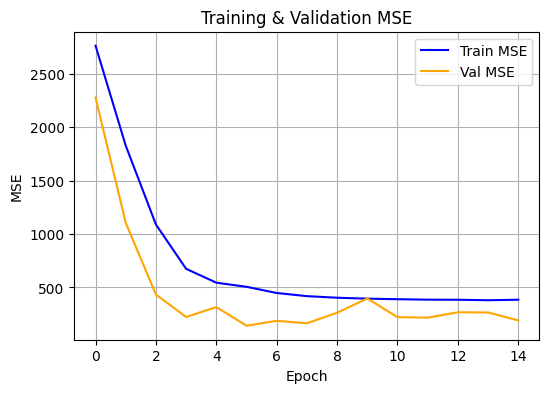

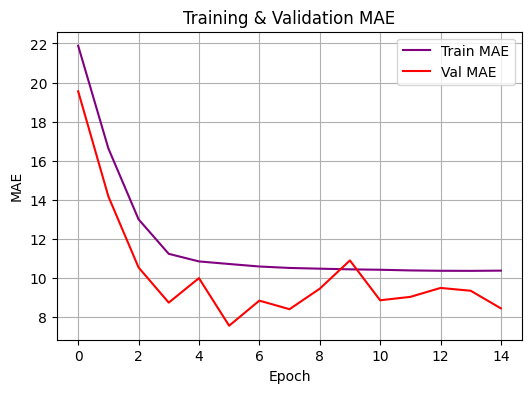

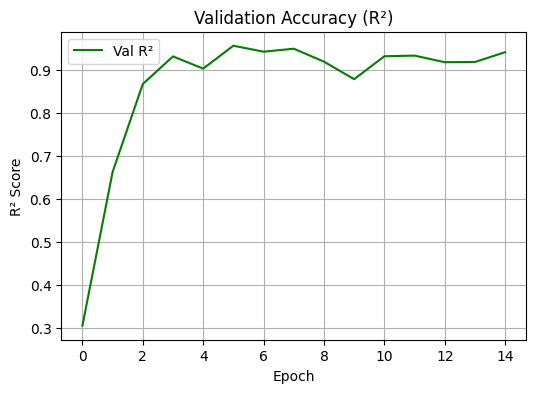

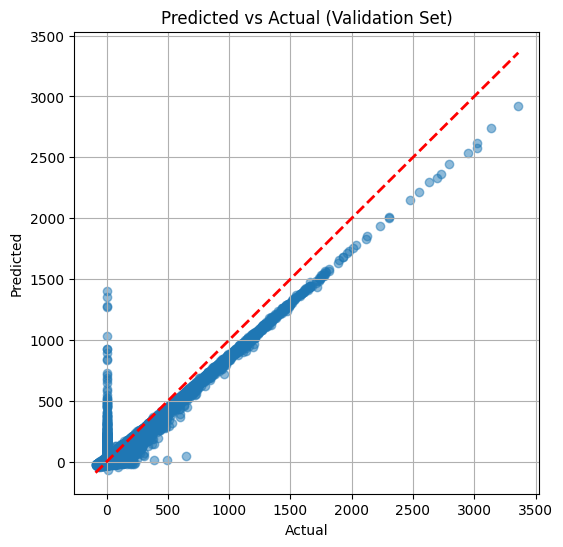

In [ ]:
plotter = TrainingPlotter(metrics, y_true=y_arr_test_t.numpy(), y_pred=final_val_pred)

plotter.plot_losses()
plotter.plot_mae()
plotter.plot_r2()
plotter.plot_pred_vs_actual()
#Dropout + BatchNorm + schedular + gradiant accumulation = 4